In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
inputfile = "GaiaSource_1584380076484244352_2200921635402776448.csv"

In [3]:
colnames = ['solution_id', 'designation', 'source_id', 'random_index', 'ref_epoch', 
            'ra', 'ra_error', 'dec', 'dec_error', 
            'parallax', 'parallax_error', 'parallax_over_error', 
            'pmra', 'pmra_error', 'pmdec', 'pmdec_error', 
            'ra_dec_corr', 'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr', 
            'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr', 
            'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
            'astrometric_n_obs_al', 'astrometric_n_obs_ac', 'astrometric_n_good_obs_al', 
            'astrometric_n_bad_obs_al', 'astrometric_gof_al', 'astrometric_chi2_al', 
            'astrometric_excess_noise', 'astrometric_excess_noise_sig', 
            'astrometric_params_solved', 'astrometric_primary_flag', 'astrometric_weight_al',
            'astrometric_pseudo_colour', 'astrometric_pseudo_colour_error', 
            'mean_varpi_factor_al', 'astrometric_matched_observations', 
            'visibility_periods_used', 'astrometric_sigma5d_max', 
            'frame_rotator_object_type', 'matched_observations', 'duplicated_source', 
            'phot_g_n_obs', 'phot_g_mean_flux', 'phot_g_mean_flux_error', 
            'phot_g_mean_flux_over_error', 'phot_g_mean_mag', 'phot_bp_n_obs', 
            'phot_bp_mean_flux', 'phot_bp_mean_flux_error', 'phot_bp_mean_flux_over_error', 
            'phot_bp_mean_mag', 'phot_rp_n_obs', 'phot_rp_mean_flux', 
            'phot_rp_mean_flux_error', 'phot_rp_mean_flux_over_error', 'phot_rp_mean_mag', 
            'phot_bp_rp_excess_factor', 'phot_proc_mode', 'bp_rp', 'bp_g', 'g_rp', 
            'radial_velocity', 'radial_velocity_error', 'rv_nb_transits', 
            'rv_template_teff', 'rv_template_logg', 'rv_template_fe_h', 'phot_variable_flag', 
            'l', 'b', 'ecl_lon', 'ecl_lat', 'priam_flags', 'teff_val', 
            'teff_percentile_lower', 'teff_percentile_upper', 'a_g_val', 
            'a_g_percentile_lower', 'a_g_percentile_upper', 'e_bp_min_rp_val', 
            'e_bp_min_rp_percentile_lower', 'e_bp_min_rp_percentile_upper', 'flame_flags', 
            'radius_val', 'radius_percentile_lower', 'radius_percentile_upper', 'lum_val', 
            'lum_percentile_lower', 'lum_percentile_upper']

In [4]:
# ra, dec in deg
# ra_err, dec_err in mas
# pm in mas/year, parallax in mas
# radial vel in km/s

def calculate_proper_motion(pmra, pmdec, dec):
    return np.sqrt(pmdec*pmdec + (pmra*math.cos(math.radians(dec)))**2)

def calculate_vt(pm, parallax):
    return 4.74*pm/parallax

def calculate_v(vt, vr):
    return np.sqrt(vt*vt + vr*vr)

def find_hvs(dec, pmra, pmdec, parallax, vr, limit=400.0):
    pm = calculate_proper_motion(pmra, pmdec, dec)
    vt = calculate_vt(pm, parallax)
    v = calculate_v(vt, vr)
    if v >= limit:
        return True, pm, vt, v
    else:
        return False, pm, vt, v

In [5]:
count = 0
noparallax = 0
bigerror = 0
hvsdata = []
with open(inputfile, "r") as ifile:
    header = ifile.readline()
    for line in ifile:
        dataline = line.strip().split(",")
        
        solution_id         = dataline[0]
        designation         = dataline[1]
        source_id           = dataline[2]
        random_index        = dataline[3]
        ref_epoch           = float(dataline[4])
        ra                  = float(dataline[5])
        ra_error            = float(dataline[6])
        dec                 = float(dataline[7])
        dec_error           = float(dataline[8])
        if dataline[9] != "": # some of the obj does not have parallax or propermotion
            if float(dataline[11]) >= 10:
                parallax            = float(dataline[9])
                parallax_error      = float(dataline[10])
                parallax_over_error = float(dataline[11])
                pmra                = float(dataline[12])
                pmra_error          = float(dataline[13])
                pmdec               = float(dataline[14])
                pmdec_error         = float(dataline[15])

                radial_velocity     = float(dataline[66])
                radial_velocity_error = float(dataline[67])

                # do something for this object/line
                # e.g. find HVS
                hvs, pm, vt, v = find_hvs(dec, pmra, pmdec, parallax, radial_velocity)
                if hvs:
                    dataline.append([pm, vt, v])
                    hvsdata.append(dataline)
            else:
                bigerror += 1
        else:
            noparallax += 1

        count += 1
        
#         # for testing
#         if count > 30:
#             break

In [6]:
print count
print noparallax
print bigerror
print len(hvsdata)

1000000
4949
199167
196


In [7]:
ra = []
dec = []
vel = []

for i,idata in enumerate(hvsdata):
    ra.append(float(idata[5]))
    dec.append(float(idata[7]))
    vel.append(idata[-1][-1])

In [8]:
print min(vel), max(vel)

400.03002225 799.134101367


In [9]:
from astropy import units as u
from astropy.coordinates import SkyCoord
from mpl_toolkits.basemap import Basemap # need to install basemap and geos 
from allskymap import AllSkyMap # need to install pyproj

In [10]:
size = 3*np.log(np.array(vel))

### Equatorial

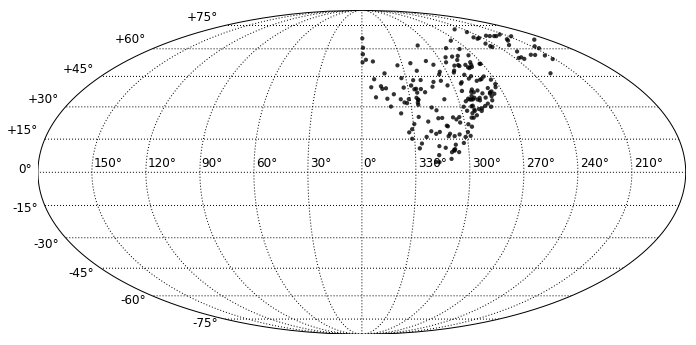

In [12]:
fig = plt.figure(figsize=(12,6))
main_ax = plt.axes([0.05, .19, .9, .75])  # rect=L,B,W,H

# Set up the projection and draw a grid.
m = AllSkyMap(ax=main_ax, projection='moll')
m.drawmapboundary(fill_color='white')
m.drawparallels(np.arange(-75,76,15), linewidth=1, dashes=[1,2], labels=[1,0,0,0], fontsize=12)
m.drawmeridians(np.arange(-150,151,30), linewidth=1, dashes=[1,2])

x, y = m(ra, dec)
cr_pts = m.scatter(x, y, s=size, c='k', marker='o', linewidths=0.5, edgecolors='none', alpha=0.8)

# Label a subset of meridians.
lons = np.arange(-150,151,30)
m.label_meridians(lons, fontsize=12, vnudge=1, halign='left', hnudge=-1)  # nudge<0 shifts to right

plt.show()

### Galactic

In [13]:
eq = SkyCoord(ra=ra, dec=dec, unit=(u.hourangle, u.deg))

In [14]:
gal = eq.galactic

In [15]:
l = gal.l.value.tolist()
b = gal.b.value.tolist()

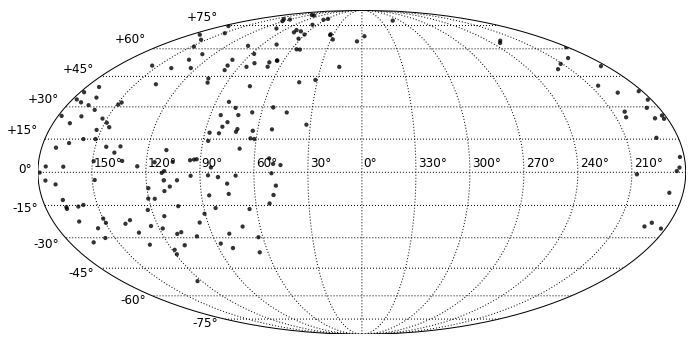

In [16]:
fig = plt.figure(figsize=(12,6))
main_ax = plt.axes([0.05, .19, .9, .75])  # rect=L,B,W,H

# Set up the projection and draw a grid.
m = AllSkyMap(ax=main_ax, projection='moll')
m.drawmapboundary(fill_color='white')
m.drawparallels(np.arange(-75,76,15), linewidth=1, dashes=[1,2], labels=[1,0,0,0], fontsize=12)
m.drawmeridians(np.arange(-150,151,30), linewidth=1, dashes=[1,2])

x, y = m(l, b)
cr_pts = m.scatter(x, y, s=size, c='k', marker='o', linewidths=0.5, edgecolors='none', alpha=0.8)

# Label a subset of meridians.
lons = np.arange(-150,151,30)
m.label_meridians(lons, fontsize=12, vnudge=1, halign='left', hnudge=-1)  # nudge<0 shifts to right

plt.show()